In [281]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import nltk
import pickle
import matplotlib.pyplot as plt
import collections

from tensorflow.keras import layers
from tensorflow.keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from nltk.translate import meteor
from rouge_score import rouge_scorer

#!pip uninstall nltk
#!pip install rouge-score
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:

pd.set_option('display.max_colwidth', None)
text = pd.read_csv("sample_data/task_2_event_summarization_train.tsv", delimiter='\t')
text_list = text['NOTES']
text = ""
for item in text_list[0:1500]:
  text = text + item.strip() + " "
text = text.lower()

filename = "sample_data/data.txt"
file = open(filename, "w")
file.write(text)
file.close()

In [ ]:
def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    #stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    #stripped_num  = tf.strings.regex_replace(stripped_html, "[\d-]", " ")
    stripped_punc  =tf.strings.regex_replace(lowercase, 
                             "[%s]" % re.escape(string.punctuation), "")    
    return stripped_punc

In [ ]:
#filename = "sample_data/train_text.txt"
raw_data_ds = tf.data.TextLineDataset(filename)
for elems in raw_data_ds.take(10):
    print(elems.numpy())

b"on 18 december 2019, tens of women demonstrated over the recent violence between edjophe and iwhreka communities. [size=tens] on 19 december 2019, employees of nipost in abuja demonstrated over the plan to outsource the stamp duty to the federal inland revenue service. [size=no report] 03 september. unidentified gunmen attacked the pdp governor primary election in ijaw and engaged police forces in a gun battle. 16 october 2019. unidentified gunmen opened fire on a car in polwaya, 10km away from birnin gwari (no location found, coded as birnin gwari) and abducted one person. around 1 may 2021 (weekend of), parcsa supporters took to the streets in oudtshoorn (eden, western cape) in a demonstration to highlight the group's concerns about race classification and to garner support for their campaign. [size=no report] on jun 29th, the village of simbalongo was attacked by aswj. 1 person was killed. 04 december (on or before). the government of cameroon established a committee for the ddr o

In [ ]:
raw_data_ds= raw_data_ds.map(lambda x: tf.strings.split(x))
for elems in raw_data_ds.take(5):
    print(elems.numpy())

[b'on' b'18' b'december' ... b'after' b'the' b'protest.']


In [ ]:
raw_data_ds=raw_data_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
for elems in raw_data_ds.take(5):
    print(elems.numpy())

b'on'
b'18'
b'december'
b'2019,'
b'tens'


In [ ]:
input_sequence_size= 4
sequence_data_ds=raw_data_ds.window(input_sequence_size+1, drop_remainder=True)
for window in sequence_data_ds.take(3):
  print(list(window.as_numpy_iterator()))

[b'on', b'18', b'december', b'2019,', b'tens']
[b'of', b'women', b'demonstrated', b'over', b'the']
[b'recent', b'violence', b'between', b'edjophe', b'and']


In [ ]:
print(window)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
sequence_data_ds = sequence_data_ds.flat_map(lambda window: window.batch(5))
for elem in sequence_data_ds.take(3):
  print(elem)

tf.Tensor([b'on' b'18' b'december' b'2019,' b'tens'], shape=(5,), dtype=string)
tf.Tensor([b'of' b'women' b'demonstrated' b'over' b'the'], shape=(5,), dtype=string)
tf.Tensor([b'recent' b'violence' b'between' b'edjophe' b'and'], shape=(5,), dtype=string)


In [ ]:
sequence_data_ds = sequence_data_ds.map(lambda window: (window[:-1], window[-1:]))
X_train_ds_raw = sequence_data_ds.map(lambda X,y: X)
y_train_ds_raw = sequence_data_ds.map(lambda X,y: y)
print(type(X_train_ds_raw))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [ ]:
print("Input X  (sequence) \t\t    ----->\t Output y (next word)")
for elem1, elem2 in zip(X_train_ds_raw.take(3),y_train_ds_raw.take(3)):
   print(elem1.numpy(),"\t\t----->\t", elem2.numpy())

Input X  (sequence) 		    ----->	 Output y (next word)
[b'on' b'18' b'december' b'2019,'] 		----->	 [b'tens']
[b'of' b'women' b'demonstrated' b'over'] 		----->	 [b'the']
[b'recent' b'violence' b'between' b'edjophe'] 		----->	 [b'and']


In [ ]:
def convert_string(X: tf.Tensor):
  str1 = ""  
  for ele in X:
    str1 += ele.numpy().decode("utf-8")+" "
  str1= tf.convert_to_tensor(str1[:-1])
  return str1

In [ ]:
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.py_function(func=convert_string,
          inp=[x], Tout=tf.string))

In [ ]:
print("Input X  (sequence) \t\t    ----->\t Output y (next word)")
for elem1, elem2 in zip(X_train_ds_raw.take(5),y_train_ds_raw.take(5)):
   print(elem1.numpy(),"\t\t----->\t", elem2.numpy())

Input X  (sequence) 		    ----->	 Output y (next word)
b'on 18 december 2019,' 		----->	 [b'tens']
b'of women demonstrated over' 		----->	 [b'the']
b'recent violence between edjophe' 		----->	 [b'and']
b'iwhreka communities. [size=tens] on' 		----->	 [b'19']
b'december 2019, employees of' 		----->	 [b'nipost']


In [ ]:
print(X_train_ds_raw.element_spec, y_train_ds_raw.element_spec)

TensorSpec(shape=<unknown>, dtype=tf.string, name=None) TensorSpec(shape=(None,), dtype=tf.string, name=None)


In [ ]:
type(X_train_ds_raw)
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.reshape(x,[1]))
type(X_train_ds_raw)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
max_features = 54762    # Number of distinct words in the vocabulary  
sequence_length = input_sequence_size    # Input sequence size
batch_size = 128                # Batch size

In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    # split --> DEFAULT: split each sample into substrings (usually words)
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
vectorize_layer.adapt(raw_data_ds.batch(batch_size))

In [ ]:
print("The size of the vocabulary (number of distinct words): ", len(vectorize_layer.get_vocabulary()))
#max_features=len(vectorize_layer.get_vocabulary())

The size of the vocabulary (number of distinct words):  6799


In [ ]:
print("The first 10 entries: ", vectorize_layer.get_vocabulary()[:10])

The first 10 entries:  ['', '[UNK]', 'the', 'in', 'of', 'on', 'and', 'a', 'to', '2021']


In [ ]:
vectorize_layer.get_vocabulary()[3]

'in'

In [ ]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

In [ ]:
for elem in X_train_ds_raw.take(3):
  print("X: ",elem.numpy())
# Vectorize the data.
X_train_ds = X_train_ds_raw.map(vectorize_text)
y_train_ds = y_train_ds_raw.map(vectorize_text)

X:  [b'on 18 december 2019,']
X:  [b'of women demonstrated over']
X:  [b'recent violence between edjophe']


In [ ]:
for elem in X_train_ds.take(3):
  print("X: ",elem.numpy())

X:  [  5 137  46  44]
X:  [  4 190  81  78]
X:  [ 505  163   43 5658]


In [ ]:
X_train_ds_raw.element_spec, y_train_ds_raw.element_spec

(TensorSpec(shape=(1,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.string, name=None))

In [ ]:
for elem in y_train_ds.take(2):
  print("shape: ", elem.shape, "\n next_char: ",elem.numpy())

shape:  (4,) 
 next_char:  [1272    0    0    0]
shape:  (4,) 
 next_char:  [2 0 0 0]


In [ ]:
y_train_ds=y_train_ds.map(lambda x: x[:1])

In [ ]:
for elem in y_train_ds.take(2):
  print("shape: ", elem.shape, "\n next_char: ",elem.numpy())

shape:  (1,) 
 next_char:  [1272]
shape:  (1,) 
 next_char:  [2]


In [ ]:
for (X,y) in zip(X_train_ds.take(5), y_train_ds.take(5)):
  print(X.numpy(),"-->",y.numpy())

[  5 137  46  44] --> [1272]
[  4 190  81  78] --> [2]
[ 505  163   43 5658] --> [6]
[5097  390 2124    5] --> [144]
[ 46  44 413   4] --> [4289]


In [ ]:
X_train_ds_raw.element_spec, y_train_ds_raw.element_spec

(TensorSpec(shape=(1,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.string, name=None))

In [ ]:
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))

In [ ]:
def _fixup_shape(X, y):
    X.set_shape([4])
    y.set_shape([1]) 
    return X, y

In [ ]:
train_ds=train_ds.map(_fixup_shape)
train_ds.element_spec

(TensorSpec(shape=(4,), dtype=tf.int64, name=None),
 TensorSpec(shape=(1,), dtype=tf.int64, name=None))

In [ ]:
for el in train_ds.take(5):
  print(el)

(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([  5, 137,  46,  44])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1272])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([  4, 190,  81,  78])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 505,  163,   43, 5658])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5097,  390, 2124,    5])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([144])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 46,  44, 413,   4])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4289])>)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(128, 4), dtype=tf.int64, name=None),
 TensorSpec(shape=(128, 1), dtype=tf.int64, name=None))

In [ ]:
def softmax(z):
   return np.exp(z)/sum(np.exp(z))
def greedy_search(conditional_probability):
  return (np.argmax(conditional_probability))
def temperature_sampling (conditional_probability, temperature=1.0):
  conditional_probability = np.asarray(conditional_probability).astype("float64")
  conditional_probability = np.log(conditional_probability) / temperature
  reweighted_conditional_probability = softmax(conditional_probability)
  probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
  return np.argmax(probas)
def top_k_sampling(conditional_probability, k):
  top_k_probabilities, top_k_indices= tf.math.top_k(conditional_probability, k=k, sorted=True)
  top_k_probabilities= np.asarray(top_k_probabilities).astype("float32")
  top_k_probabilities= np.squeeze(top_k_probabilities)
  top_k_indices = np.asarray(top_k_indices).astype("int32")
  top_k_redistributed_probability=softmax(top_k_probabilities)
  top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
  sampled_token = np.random.choice(np.squeeze(top_k_indices), p=top_k_redistributed_probability)
  return sampled_token

In [ ]:

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")
x = layers.Embedding(max_features, sequence_length)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.Flatten()(x)
predictions=  layers.Dense(max_features, activation='softmax')(x)
model_LSTM = tf.keras.Model(inputs, predictions,name="model_LSTM")
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())


Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 embedding (Embedding)       (None, 4, 4)              219048    
                                                                 
 dropout (Dropout)           (None, 4, 4)              0         
                                                                 
 lstm (LSTM)                 (None, 4, 128)            68096     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 54762)             28092906  
                                                                 
Total params: 28,380,050
Trainable params: 28,380,050
No

In [ ]:
'''
inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")
x = layers.Embedding(max_features, sequence_length)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
#x = layers.Flatten()(x)
predictions = layers.Dense(max_features, activation='softmax')(x)
model_LSTM = tf.keras.Model(inputs, predictions, name="model_LSTM")
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())
#model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam')
'''

'''
model = Sequential()
model.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(Y_modified.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
'''

"\nmodel = Sequential()\nmodel.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(400, return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(400))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(Y_modified.shape[1], activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam')\n"

In [ ]:
model_history=model_LSTM.fit(train_ds, epochs=100)

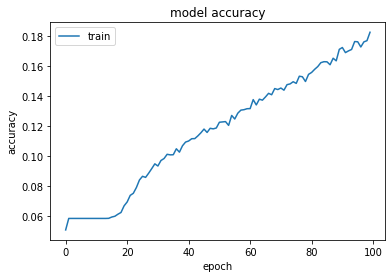

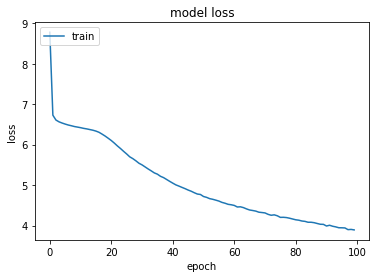

In [ ]:
#model = tf.keras.models.load_model('sample_data/datapipelinelstm')
plt.plot(model_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
candidate_texts = []
def decode_sequence (encoded_sequence):
  deceoded_sequence=[]
  for token in encoded_sequence:
    deceoded_sequence.append(vectorize_layer.get_vocabulary()[token])
  sequence= ' '.join(deceoded_sequence)
  #print("\t",sequence)
  candidate_texts.append(sequence)
  return sequence

In [ ]:

def generate_text(model, seed_original, step):
    seed= vectorize_text(seed_original)
    print("The prompt is")
    decode_sequence(seed.numpy().squeeze())
    

    seed= vectorize_text(seed_original).numpy().reshape(1,-1)
    '''#Text Generated by Greedy Search Sampling
    generated_greedy_search = (seed)
    for i in range(step):
      predictions=model.predict(seed)
      next_index= greedy_search(predictions.squeeze())
      generated_greedy_search = np.append(generated_greedy_search, next_index)
      seed= generated_greedy_search[-sequence_length:].reshape(1,sequence_length)
    print("Text Generated by Greedy Search Sampling:")
    decode_sequence(generated_greedy_search)
    '''

    #Text Generated by Temperature Sampling
    print("Text Generated by Temperature Sampling:")
    for temperature in [0.2, 1.0, 1.2]:
        print("\ttemperature: ", temperature)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        generated_temperature = (seed)
        for i in range(step):
            predictions=model.predict(seed)
            next_index = temperature_sampling(predictions.squeeze(), temperature)
            generated_temperature = np.append(generated_temperature, next_index)
            seed= generated_temperature[-sequence_length:].reshape(1,sequence_length)
        decode_sequence(generated_temperature)


    #Text Generated by Top-K Sampling
    print("Text Generated by Top-K Sampling:")
    for k in [2, 3, 4]:
        print("\tTop-k: ", k)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        generated_top_k = (seed)
        for i in range(step):
            predictions=model.predict(seed)
            next_index = top_k_sampling(predictions.squeeze(), k)
            generated_top_k = np.append(generated_top_k, next_index)
            seed= generated_top_k[-sequence_length:].reshape(1,sequence_length)
        decode_sequence(generated_top_k)
    return candidate_texts

In [ ]:
model=tf.keras.models.load_model('sample_data/datapipelinelstm/datapipelinelstm')
#t=generate_text(model,"18-Dec-19 Vanguard (Nigeria) 0 Protests Peaceful protest Protesters (Nigeria) 6 0 60 Iwhreka", 50)

In [ ]:
#model_LSTM.save('sample_data/datapipelinelstm')

In [ ]:
#from google.colab import files

In [ ]:
#!unzip sample_data/datapipelinelstm.zip -d sample_data/datapipelinelstm

Archive:  sample_data/datapipelinelstm.zip
   creating: sample_data/datapipelinelstm/datapipelinelstm/assets/
  inflating: sample_data/datapipelinelstm/datapipelinelstm/keras_metadata.pb  
  inflating: sample_data/datapipelinelstm/datapipelinelstm/saved_model.pb  
   creating: sample_data/datapipelinelstm/datapipelinelstm/variables/
  inflating: sample_data/datapipelinelstm/datapipelinelstm/variables/variables.data-00000-of-00001  
  inflating: sample_data/datapipelinelstm/datapipelinelstm/variables/variables.index  


In [ ]:
pd_train_data=pd.read_csv("sample_data/task_2_event_summarization_train.tsv", delimiter='\t')
dict_train_data=pd_train_data.to_dict(orient='records')

In [ ]:
import json
sampling_size = 100
data = dict_train_data[0:sampling_size]
candidate_text_dict = {}
reference_str = {}
i = 1
for item in data:
  test_str = item['EVENT_DATE'] + " " + item['SOURCE'] + " " +  str(item['FATALITIES']) + " " +  item['EVENT_TYPE'] + " " +  item['SUB_EVENT_TYPE'] + " " +  str(item['ACTOR1']) + " " +  str(item['INTER1']) + " " +  str(item['ACTOR2']) + " " +  str(item['INTER2']) + " " +  str(item['INTERACTION']) + " " +  item['LOCATION']
  reference_str[i] = item['NOTES']
  candidate_text_dict[i] = generate_text(model, test_str, 50)
  i = i + 1
  print(test_str)
  print(reference_str)

In [ ]:
'''
#import pickle
with open('sample_data/reference_str.pickle', 'wb') as handle:
    pickle.dump(reference_str, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('sample_data/candidate_text_dict.pickle', 'wb') as handle:
    pickle.dump(candidate_text_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

'''
reference_str = {}
candidate_text_dict = {}
with open('sample_data/reference_str.pickle', 'rb') as f:
    reference_str = pickle.load(f)
with open('sample_data/candidate_text_dict.pickle', 'rb') as f:
    candidate_text_dict = pickle.load(f)
'''

"\nreference_str = {}\ncandidate_text_dict = {}\nwith open('sample_data/reference_str.pickle', 'rb') as f:\n    reference_str = pickle.load(f)\nwith open('sample_data/candidate_text_dict.pickle', 'rb') as f:\n    candidate_text_dict = pickle.load(f)\n"

In [ ]:
def preprocess(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.lower()
  text = text.split()
  return text

In [ ]:
tokenized_ref = preprocess(reference_str[1])
tokenized_candidate = preprocess(candidate_text_dict[1][1])
meteor([tokenized_candidate], tokenized_ref)
#print(nltk.translate.)

0.02976190476190476

In [ ]:
def getRogueScore(str1, str2):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
  scores = scorer.score(str1, str2)
  return scores['rouge1'][0], scores['rouge1'][1], scores['rouge1'][2]

In [ ]:
meteor_scores = {}
precision_score = {}
recall_score = {}
f_measure = {}

for i in range(1, sampling_size + 1):
  tokenized_ref = preprocess(reference_str[i])
  max_meteor = -10
  for txt in candidate_text_dict[i]:
    tokenized_candidate = preprocess(txt)
    max_meteor = max(max_meteor, meteor([tokenized_candidate], tokenized_ref))
    precision_score[i], recall_score[i], f_measure[i] = getRogueScore(txt, reference_str[i])
  meteor_scores[i] = max_meteor
print(meteor_scores)
print(precision_score)
print(recall_score)
print(f_measure)

{1: 0.10556175595238095, 2: 0.15600787706611566, 3: 0.11540526033279656, 4: 0.12363813229571984, 5: 0.2034536328871893, 6: 0.140188373253493, 7: 0.11517763654515793, 8: 0.11406844106463879, 9: 0.1771789665725047, 10: 0.13338596994927743, 11: 0.12305068226120858, 12: 0.21018643416156754, 13: 0.2818181818181818, 14: 0.09803921568627452, 15: 0.12244701348747591, 16: 0.1455968688845401, 17: 0.18209134615384615, 18: 0.11316872427983539, 19: 0.20511783049776972, 20: 0.21627906976744188, 21: 0.13287096620429956, 22: 0.12436399217221134, 23: 0.15930565774696973, 24: 0.1972276369937189, 25: 0.13602205631191136, 26: 0.18057971449136276, 27: 0.1455968688845401, 28: 0.14645669291338584, 29: 0.103912353515625, 30: 0.20439560439560442, 31: 0.13907797029702967, 32: 0.1927195767195767, 33: 0.14703557312252963, 34: 0.11358114674441203, 35: 0.23379629629629628, 36: 0.19658119658119658, 37: 0.19772189984955943, 38: 0.10556175595238095, 39: 0.2093977421009238, 40: 0.20004348771472058, 41: 0.13364497183267

In [ ]:
#plotting meteor
myList = meteor_scores.items()
myList = sorted(myList)
x, y = zip(*myList)
plt.plot(x,y)
plt.title('Meteor Score')
plt.ylabel('Meteor Score')
plt.xlabel('Sample')
plt.legend(['Meteor', 'Sample'], loc='upper right')
plt.show()


#plotting precision
myList = precision_score.items()
myList = sorted(myList)
x, y = zip(*myList)
plt.plot(x,y)
plt.title('Precision Score')
plt.ylabel('Precision')
plt.xlabel('Sample')
plt.legend(['Precision', 'Sample'], loc='upper right')
plt.show()

#plotting recall
myList = recall_score.items()
myList = sorted(myList)
x, y = zip(*myList)
plt.plot(x,y)
plt.title('Recall Score')
plt.ylabel('Recall')
plt.xlabel('Sample')
plt.legend(['Recall', 'Sample'], loc='upper right')
plt.show()

#plotting f_measure
myList = f_measure.items()
myList = sorted(myList)
x, y = zip(*myList)
plt.plot(x,y)
plt.title('F Measure Score')
plt.ylabel('F Measure')
plt.xlabel('Sample')
plt.legend(['F Measure', 'Sample'], loc='upper right')
plt.show()

In [ ]:
avg_meteor = np.mean(list(meteor_scores.values()))
avg_precision = np.mean(list(precision_score.values()))
avg_recall = np.mean(list(recall_score.values()))
avg_fmeasure = np.mean(list(f_measure.values()))

In [ ]:
print(avg_meteor)
print(avg_precision)
print(avg_recall)
print(avg_fmeasure)

0.16055468643540982
0.2522307881979318
0.1548148148148148
0.18652300459908894


In [267]:
#Perplexity
def unigram(tokens):    
    model = collections.defaultdict(lambda: 0.01)
    for f in tokens:
        try:
            model[f] += 1
        except KeyError:
            model [f] = 1
            continue
    N = float(sum(model.values()))
    for word in model:
        model[word] = model[word]/N
    return model

In [289]:
def perplexity(testset, model):
    testset = testset.split()
    perplexity = 1
    N = 0
    for word in testset:
        N += 1
        perplexity = perplexity * (1/model[word])
    perplexity = pow(perplexity, 1/float(N)) 
    return perplexity

In [ ]:
perplexity_score = {}
for i in range(1, sampling_size + 1):
  min_perplexity = 560000
  tokens = nltk.word_tokenize(reference_str[i])
  model_unigram = unigram(tokens)
  for txt in candidate_text_dict[i]:
    p = perplexity(' '.join(preprocess(txt)), model_unigram)
    min_perplexity = min(min_perplexity, p)
  perplexity_score[i] = min_perplexity


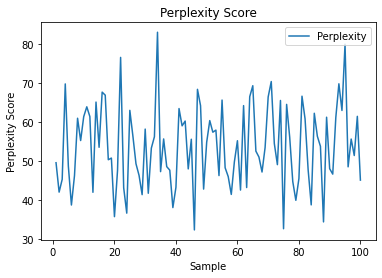

In [301]:
#plotting meteor
myList = perplexity_score.items()
myList = sorted(myList)
x, y = zip(*myList)
plt.plot(x,y)
plt.title('Perplexity Score')
plt.ylabel('Perplexity Score')
plt.xlabel('Sample')
plt.legend(['Perplexity', 'Sample'], loc='upper right')
plt.show()

In [299]:
perplexity_avg = np.mean(list(perplexity_score.values()))

In [300]:
perplexity_avg

53.81035902255277